In [10]:
import sys
from pathlib import Path

import cProfile
import re


# Add the 'src' directory to the Python path
src_path = Path('../src').resolve()
sys.path.append(str(src_path))

from aspire.volume import Volume
import mrcfile
import numpy as np 
import numpy.linalg as LA 
from viewing_direction import *
from utils import *
from aspire.basis.basis_utils import lgwt
from volume import *
from moments import * 
import matplotlib.pyplot as plt


In [11]:
# plot vMF density 

c = 10
centers = np.random.normal(0,1,size=(c,3))
centers /= LA.norm(centers, axis=1, keepdims=True)
w_vmf = np.random.uniform(0,1,c)
w_vmf = w_vmf/np.sum(w_vmf)


ngrid = 50 
_ths = np.pi*np.arange(ngrid)/ngrid
_phs = 2*np.pi*np.arange(ngrid)/ngrid

ths, phs = np.meshgrid(_ths,_phs,indexing='ij')
ths, phs = ths.flatten(), phs.flatten()

grid = Grid_3d(type='spherical', ths=ths, phs=phs)


kappa = 5
f_vmf = vMF_density(centers,w_vmf,kappa,grid)
f_vmf = f_vmf*np.sin(ths)
f_vmf = f_vmf.reshape((ngrid,ngrid))

In [12]:
# rejection sampling from vMF 
N = 10000
samples = sample_vmf(N,centers,w_vmf,kappa,C=.5)

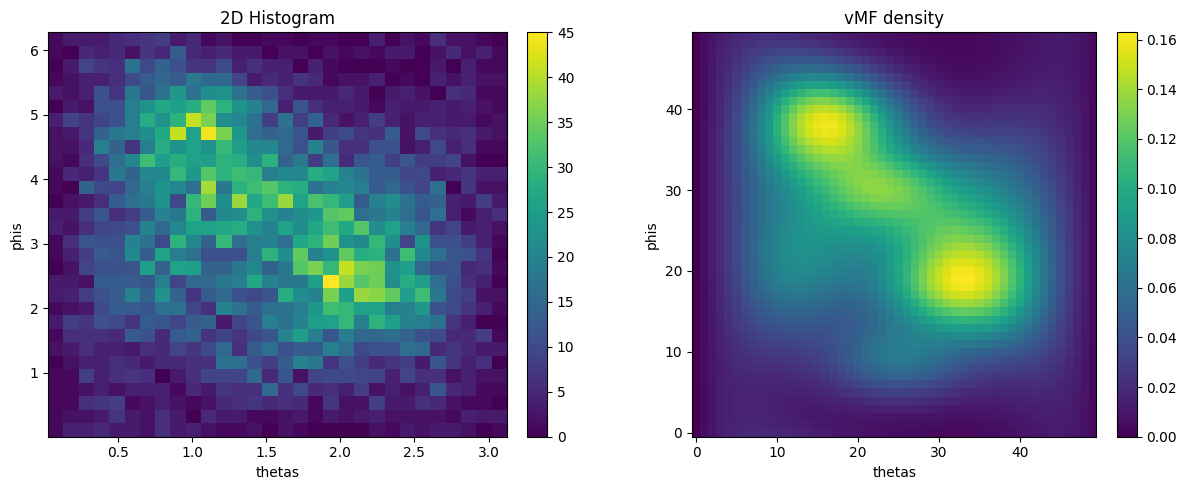

In [13]:
rs, ths, phs = cart2sph(samples[:,0], samples[:,1], samples[:,2])
# Create a single figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure to fit both plots

# First subplot: 2D Histogram
im1 = axes[0].hist2d(ths, phs, bins=30, cmap="viridis")
fig.colorbar(im1[3], ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar
axes[0].set_title("2D Histogram")
axes[0].set_xlabel("thetas")
axes[0].set_ylabel("phis")

# Second subplot: vMF Density
im2 = axes[1].imshow(f_vmf.T, cmap='viridis', interpolation='nearest', origin='lower')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar
axes[1].set_title("vMF density")
axes[1].set_xlabel("thetas")
axes[1].set_ylabel("phis")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

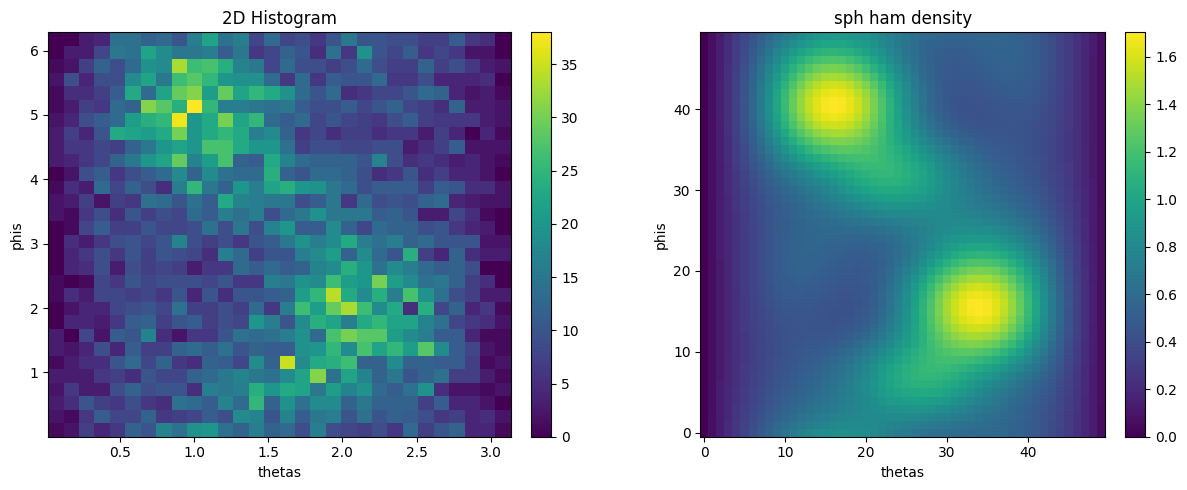

In [14]:
# expand the symmetrized density and draw samples 
def my_fun(th,ph):
    grid = Grid_3d(type='spherical', ths=np.array([th]),phs=np.array([ph]))
    return 4*np.pi*vMF_density(centers,w_vmf,kappa,grid)[0]

ell_max_half_view = 4
sph_coef, indices = sph_harm_transform(my_fun, ell_max_half_view)

f_vmf_expand = sph_harm_eval(sph_coef, ell_max_half_view, grid)
f_vmf_expand = f_vmf_expand*np.sin(grid.ths)
f_vmf_expand = np.real(f_vmf_expand.reshape([ngrid, ngrid]))


# plt.imshow(f_vmf_expand.T, cmap='viridis', interpolation='nearest', origin='lower')
# plt.colorbar(label='Value')  # Add a colorbar for reference
# plt.title("vMF density")
# plt.xlabel("thetas")
# plt.ylabel("phis")
# plt.show()


samples = sample_sph_coef(N, sph_coef, ell_max_half_view, C=5.0)
rs, ths, phs = cart2sph(samples[:,0], samples[:,1], samples[:,2])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure to fit both plots

# First subplot: 2D Histogram
im1 = axes[0].hist2d(ths, phs, bins=30, cmap="viridis")
fig.colorbar(im1[3], ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar
axes[0].set_title("2D Histogram")
axes[0].set_xlabel("thetas")
axes[0].set_ylabel("phis")

# Second subplot: vMF Density
im2 = axes[1].imshow(f_vmf_expand.T, cmap='viridis', interpolation='nearest', origin='lower')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar
axes[1].set_title("sph ham density")
axes[1].set_xlabel("thetas")
axes[1].set_ylabel("phis")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [15]:
# get the spherical FB coefficient of the volume
with mrcfile.open('../data/emd_34948.map') as mrc:
    data = mrc.data

Vol = Volume(data)
ds_res = 64 
Vol = Vol.downsample(ds_res)
vol = Vol.asnumpy()
vol = vol[0]


ell_max_vol = 5
# spherical bessel transform 
vol_coef, k_max, r0, indices_vol = sphFB_transform(vol, ell_max_vol)

In [16]:
# form moments using quadrature method 
r2_max = 50 
r3_max = 50 
sketch_size = 30 
tol2 = 0.01 
tol3 = 0.01 
grid = get_2d_unif_grid(ds_res,1/ds_res)
grid = Grid_3d(xs=grid.xs, ys=grid.ys, zs=np.zeros(grid.ys.shape))

opts = {}
opts['r2_max'] = r2_max
opts['r3_max'] = r3_max
opts['sketch_size'] = sketch_size
opts['tol2'] = tol2 
opts['tol3'] = tol3 
opts['grid'] = grid

rot_coef = sph_t_rot_coef(sph_coef, ell_max_half_view)
subMoMs = coef_t_subspace_moments(vol_coef, ell_max_vol, k_max, r0, indices_vol, rot_coef, ell_max_half_view, opts)

forming the first moment
sampling the second moment


In [17]:
# form moments using Monte Carlo
M1 = subMoMs['M1']
M2 = subMoMs['M2']
G = subMoMs['G']
_, betas, alphas = cart2sph(samples[:,0],samples[:,1],samples[:,2]) 
gammas = np.random.uniform(0,2*np.pi,(N,))

M1_emp = 0 
M2_emp = 0
for i in range(N):
    Rot = Rz(alphas[i]) @ Ry(betas[i]) @ Rz(gammas[i])
    grid_proj = grid.get_rotated_grid(Rot)
    fft_img = sphFB_eval(vol_coef, ell_max_vol, k_max, r0, indices_vol, grid_proj)
    M1_emp += fft_img/N 
    fft_img = fft_img.reshape(-1,1)
    M2_emp += fft_img @ (np.conj(fft_img).T@G)/N


# compare the moments obtained by quadrature and Monte Carlo
print(LA.norm(M1_emp-M1)/LA.norm(M1), LA.norm(M2_emp-M2)/LA.norm(M2))


0.0049171107498018965 0.008317440788828902
